In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [34]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_1lead = import_afc_data()

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

100%|██████████| 8528/8528 [00:00<00:00, 21372.10it/s]


In [6]:
data_12lead = import_balanced_12lead_data()

dataset_12lead = WindowDataset(data_12lead, labelmap, device=device)

In [7]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
~     279
Name: count, dtype: int64

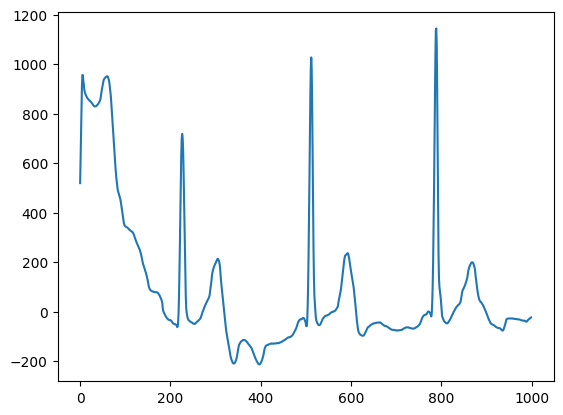

In [8]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[3][0])

In [9]:
value_counts = dataset_1lead.get_value_counts()
weights = [sum(value_counts)/x for x in value_counts]
weights[labelmap['~']] = weights[labelmap['N']]

# Training

In [12]:
## Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap

history = train_kfold_model(dataset_1lead, trainparams)

plot_tt_graph(history, idx=0)
display_results(history,trainparams.k)

Fold 1
Epoch:10/100 AVG Training Loss:0.02518 AVG Test Loss:0.02557 AVG Training Acc 53.56 % AVG Test Acc 57.09 %
Epoch:20/100 AVG Training Loss:0.02304 AVG Test Loss:0.02383 AVG Training Acc 60.32 % AVG Test Acc 61.72 %
Epoch:30/100 AVG Training Loss:0.02243 AVG Test Loss:0.02242 AVG Training Acc 61.05 % AVG Test Acc 60.38 %
Epoch:40/100 AVG Training Loss:0.02191 AVG Test Loss:0.02211 AVG Training Acc 61.90 % AVG Test Acc 65.01 %
Epoch:50/100 AVG Training Loss:0.02099 AVG Test Loss:0.02158 AVG Training Acc 64.38 % AVG Test Acc 67.53 %
Epoch:60/100 AVG Training Loss:0.02104 AVG Test Loss:0.02210 AVG Training Acc 62.59 % AVG Test Acc 69.17 %
Epoch:70/100 AVG Training Loss:0.02023 AVG Test Loss:0.02021 AVG Training Acc 64.92 % AVG Test Acc 65.94 %
Epoch:80/100 AVG Training Loss:0.01998 AVG Test Loss:0.02051 AVG Training Acc 65.07 % AVG Test Acc 70.22 %
Epoch:90/100 AVG Training Loss:0.02019 AVG Test Loss:0.01942 AVG Training Acc 63.30 % AVG Test Acc 67.94 %
Epoch:100/100 AVG Training Los

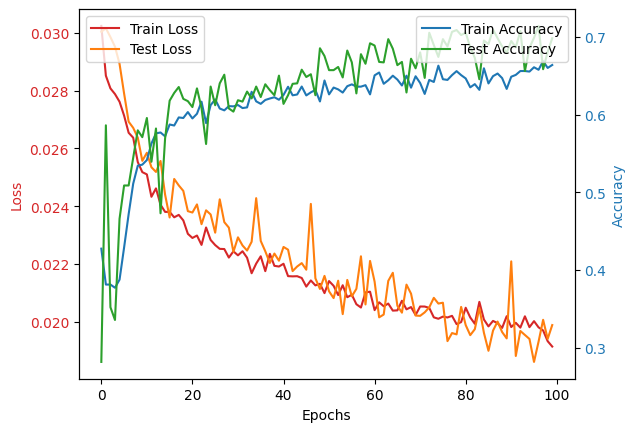

In [23]:
plot_tt_graph(history, idx=0)

In [26]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/100 AVG Training Loss:0.02492 AVG Test Loss:0.02374 AVG Training Acc 53.78 % AVG Test Acc 53.11 %
Epoch:20/100 AVG Training Loss:0.02297 AVG Test Loss:0.02201 AVG Training Acc 60.07 % AVG Test Acc 63.16 %
Epoch:30/100 AVG Training Loss:0.02190 AVG Test Loss:0.02143 AVG Training Acc 62.22 % AVG Test Acc 67.68 %
Epoch:40/100 AVG Training Loss:0.02145 AVG Test Loss:0.02019 AVG Training Acc 62.59 % AVG Test Acc 68.25 %
Epoch:50/100 AVG Training Loss:0.02059 AVG Test Loss:0.02005 AVG Training Acc 64.80 % AVG Test Acc 68.76 %
Epoch:60/100 AVG Training Loss:0.02032 AVG Test Loss:0.01870 AVG Training Acc 66.35 % AVG Test Acc 69.18 %
Epoch:70/100 AVG Training Loss:0.02016 AVG Test Loss:0.01950 AVG Training Acc 64.67 % AVG Test Acc 70.99 %
Epoch:80/100 AVG Training Loss:0.01957 AVG Test Loss:0.02001 AVG Training Acc 65.70 % AVG Test Acc 70.92 %
Epoch:90/100 AVG Training Loss:0.01985 AVG Test Loss:0.01906 AVG Training Acc 65.99 % AVG Test Acc 70.80 %
Epoch:100/100 AVG Training Loss:0.019

In [31]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=5

history = train_kfold_transfer_model(dataset_12lead, buffer, trainparams, test=True)

plot_tt_graph(history, idx=0)
display_results(history, k=trainparams.k)

Fold 1
Epoch:10/100 AVG Training Loss:0.00478 AVG Test Loss:0.00467 AVG Training Acc 75.51 % AVG Test Acc 76.96 %
Epoch:20/100 AVG Training Loss:0.00466 AVG Test Loss:0.00473 AVG Training Acc 77.02 % AVG Test Acc 78.46 %
Epoch:30/100 AVG Training Loss:0.00451 AVG Test Loss:0.00437 AVG Training Acc 78.60 % AVG Test Acc 78.92 %
Epoch:40/100 AVG Training Loss:0.00430 AVG Test Loss:0.00422 AVG Training Acc 80.11 % AVG Test Acc 80.72 %
Epoch:50/100 AVG Training Loss:0.00420 AVG Test Loss:0.00456 AVG Training Acc 80.97 % AVG Test Acc 79.52 %
Epoch:60/100 AVG Training Loss:0.00426 AVG Test Loss:0.00499 AVG Training Acc 80.29 % AVG Test Acc 79.37 %
Epoch:70/100 AVG Training Loss:0.00417 AVG Test Loss:0.00464 AVG Training Acc 81.42 % AVG Test Acc 81.33 %
Epoch:80/100 AVG Training Loss:0.00407 AVG Test Loss:0.00459 AVG Training Acc 82.78 % AVG Test Acc 80.57 %
Epoch:90/100 AVG Training Loss:0.00398 AVG Test Loss:0.00470 AVG Training Acc 81.99 % AVG Test Acc 79.07 %
Epoch:100/100 AVG Training Los

In [35]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap

history = train_control_12lead_model(dataset_12lead, trainparams)

plot_tt_graph(history, idx=0)
display_results(history, k=trainparams.k)

Fold 1
Epoch:10/100 AVG Training Loss:0.00610 AVG Test Loss:0.00662 AVG Training Acc 66.73 % AVG Test Acc 67.77 %
Epoch:20/100 AVG Training Loss:0.00482 AVG Test Loss:0.00510 AVG Training Acc 74.11 % AVG Test Acc 73.80 %
Epoch:30/100 AVG Training Loss:0.00470 AVG Test Loss:0.00503 AVG Training Acc 75.09 % AVG Test Acc 75.45 %
Epoch:40/100 AVG Training Loss:0.00419 AVG Test Loss:0.00515 AVG Training Acc 77.09 % AVG Test Acc 77.26 %
Epoch:50/100 AVG Training Loss:0.00422 AVG Test Loss:0.00452 AVG Training Acc 77.17 % AVG Test Acc 78.16 %
Epoch:60/100 AVG Training Loss:0.00401 AVG Test Loss:0.00510 AVG Training Acc 77.92 % AVG Test Acc 77.71 %
Epoch:70/100 AVG Training Loss:0.00383 AVG Test Loss:0.00469 AVG Training Acc 80.56 % AVG Test Acc 76.51 %
Epoch:80/100 AVG Training Loss:0.00387 AVG Test Loss:0.00475 AVG Training Acc 78.90 % AVG Test Acc 79.07 %
Epoch:90/100 AVG Training Loss:0.00385 AVG Test Loss:0.00503 AVG Training Acc 80.60 % AVG Test Acc 77.41 %
Epoch:100/100 AVG Training Los

KeyboardInterrupt: 